# Simple RAG with LangChain and Claude 3

## Overview
In this lab, we will build a simple question & answer application with Claude 3, Titan Embeddings and LangChain.

Large language models are prone to hallucination, which is just a fancy word for making up a response. To correctly and consistently answer questions, we need to ensure that the model has real information available to support its responses. We use the Retrieval-Augmented Generation (RAG) pattern to make this happen.

With Retrieval-Augmented Generation, we first pass a user's prompt to a data store. This might be in the form of a query to Amazon Kendra. We could also create a numerical representation of the prompt using Amazon Titan Embeddings to pass to a vector database. We then retrieve the most relevant content from the data store to support the large language model's response.

In this lab, we will use an in-memory FAISS  database to demonstrate the RAG pattern. In a real-world scenario, you will most likely want to use a persistent data store like Amazon Kendra or the vector engine like Amazon OpenSearch Serverless.

## Architecture
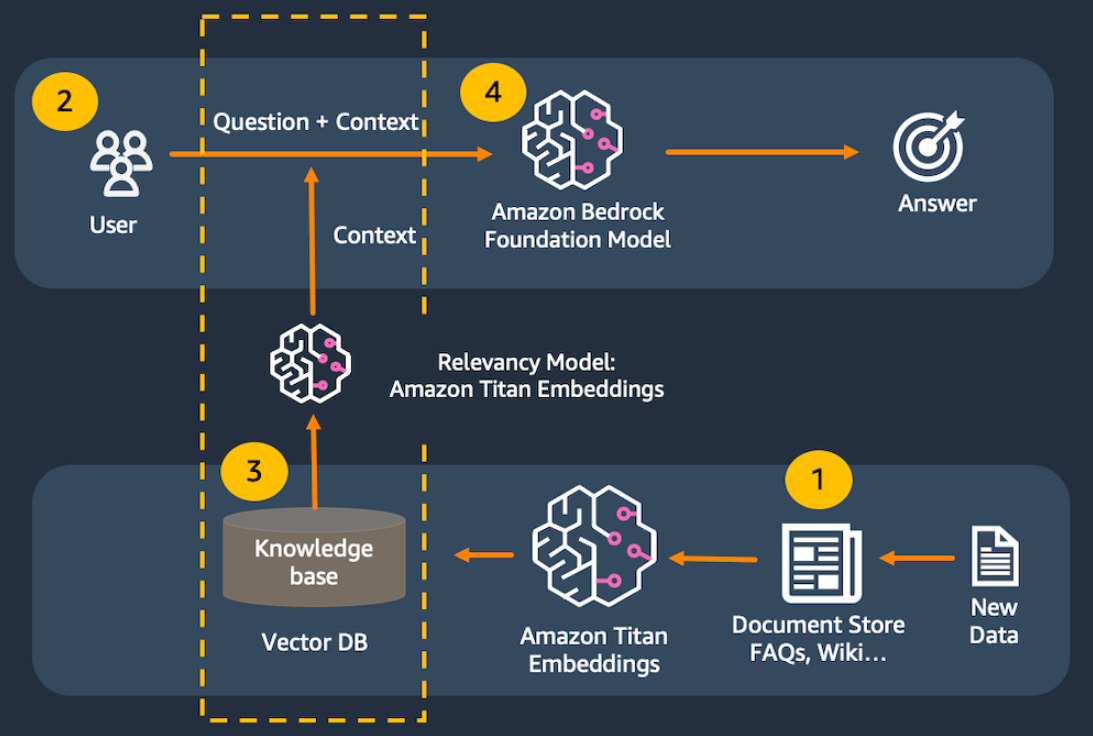

1. A document is broken up into chunks of text. The chunks are passed to Titan Embeddings to be converted to vectors. The vectors are then saved to the vector database.
2. The user submits a question.
3. The question is converted to a vector using Amazon Titan Embeddings, then matched to the closest vectors in the vector database.
4. The combined content from the matching vectors + the original question are then passed to the large language model to get the best answer.

## Implementation

In [ ]:
!pip install langchain==0.2.5
!pip install langchain_text_splitters==0.2.1
!pip install langchain_aws==0.1.10
!pip install langchain_community==0.2.5
!pip install pypdf

In [2]:
from langchain_community.embeddings import BedrockEmbeddings
from langchain.indexes import VectorstoreIndexCreator
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_aws import ChatBedrock

### Define RAG functions

In [3]:
def get_llm():
    
    llm = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0")
    
    return llm

In [4]:
def get_index(): #creates and returns an in-memory vector store to be used in the application
    
    embeddings = BedrockEmbeddings() #create a Titan Embeddings client
    
    pdf_path = "data/AMZN-2022-Shareholder-Letter.pdf" #assumes local PDF file with this name

    loader = PyPDFLoader(file_path=pdf_path) #load the pdf file
    
    text_splitter = RecursiveCharacterTextSplitter( #create a text splitter
        separators=["\n\n", "\n", ".", " "], #split chunks at (1) paragraph, (2) line, (3) sentence, or (4) word, in that order
        chunk_size=1000, #divide into 1000-character chunks using the separators above
        chunk_overlap=100 #number of characters that can overlap with previous chunk
    )
    
    index_creator = VectorstoreIndexCreator( #create a vector store factory
        vectorstore_cls=FAISS, #use an in-memory vector store for demo purposes
        embedding=embeddings, #use Titan embeddings
        text_splitter=text_splitter, #use the recursive text splitter
    )
    
    index_from_loader = index_creator.from_loaders([loader]) #create an vector store index from the loaded PDF
    
    return index_from_loader #return the index to be cached by the client app

In [5]:
def get_rag_response(index, question): #rag client function
    
    llm = get_llm()
    
    response_text = index.query(question=question, llm=llm) #search against the in-memory index, stuff results into a prompt and send to the llm
    
    return response_text

### Build index from pdf

In [6]:
index = get_index()

### Test QA

In [7]:
""" sample questions:
What are some of the current strategic initiatives for the company?
What is the company's strategy for generative AI?
What are the key growth drivers for the company?
"""
question = "What are the key growth drivers for the company?"
res = get_rag_response(index, question)
print(res)

The passage does not explicitly state the key growth drivers for the company. However, it emphasizes a few key points that seem related to the company's growth strategy:

1. Focus on attracting and retaining talented employees, and compensating them significantly with stock options to make them think and act like owners.

2. Obsessing over providing compelling value to customers.

3. Aggressive investment to expand the customer base, brand, and infrastructure to establish an enduring franchise.

4. Pursuing online commerce opportunities in large markets, even if it requires significant investment and execution against established competitors. 

5. Aiming to solidify and extend their current market leadership position to drive long-term shareholder value.

So while not directly stated, some potential key growth drivers implied are talent acquisition/retention, customer obsession, brand building, infrastructure investment, market expansion, and solidifying their leadership position in co